In [1]:
#https://www.youtube.com/watch?v=fATVVQfFyU0&t=609s&ab_channel=NeuralNine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
titanic_data = pd.read_csv("./train.csv")
titanic_data = titanic_data.drop('Name', axis=1)

In [3]:
titanic_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S


<Axes: >

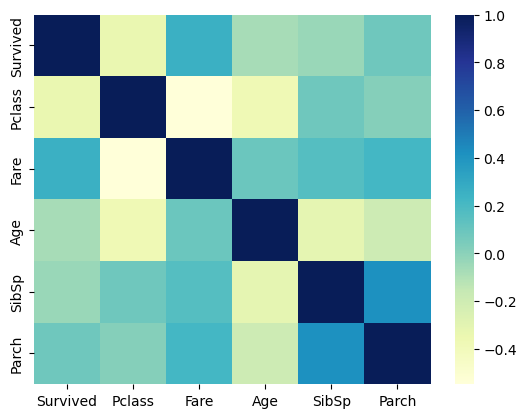

In [4]:
import seaborn as sns
#подивитися на кореляцію
sns.heatmap(titanic_data[['Survived', 'Pclass', 'Fare',"Age","SibSp","Parch"]].corr(), cmap="YlGnBu")

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(titanic_data, titanic_data[["Survived", "Pclass", "Sex"]]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]


<Axes: >

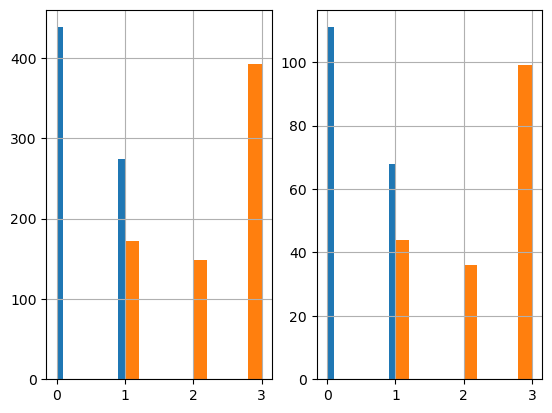

In [6]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()

plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()

In [7]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 737 to 760
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Sex          712 non-null    object 
 4   Age          563 non-null    float64
 5   SibSp        712 non-null    int64  
 6   Parch        712 non-null    int64  
 7   Ticket       712 non-null    object 
 8   Fare         712 non-null    float64
 9   Cabin        160 non-null    object 
 10  Embarked     711 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 66.8+ KB


In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy="mean")
        X['Age'] = imputer.fit_transform(X[['Age']])
        
        #imputer = SimpleImputer(strategy="mean")
        # Створення нового DataFrame, оновленого значеннями Age
        #X_transformed = pd.DataFrame(imputer.fit_transform(X[['Age']]), columns=['Age'])
        # Повертання оновленого DataFrame

        return X
    

In [9]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        
        column_names = ["C", "S", "Q", "N"]
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
            
        matrix = encoder.fit_transform(X[['Sex']]).toarray()
            
        column_names = ["Female", "Male"]
        
        for i in range (len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
            
        return X
        

In [10]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(["Embarked"], axis=1, errors="ignore")

In [11]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("ageimputer", AgeImputer()),
    ("featureencoder", FeatureEncoder()),
    ("featuredropper", FeatureDropper())
])

In [12]:
strat_train_set = pipeline.fit_transform(strat_train_set)

In [16]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 737 to 760
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Sex          712 non-null    object 
 4   Age          712 non-null    float64
 5   SibSp        712 non-null    int64  
 6   Parch        712 non-null    int64  
 7   Ticket       712 non-null    object 
 8   Fare         712 non-null    float64
 9   Cabin        160 non-null    object 
 10  C            712 non-null    float64
 11  S            712 non-null    float64
 12  Q            712 non-null    float64
 13  N            712 non-null    float64
 14  Female       712 non-null    float64
 15  Male         712 non-null    float64
dtypes: float64(8), int64(5), object(3)
memory usage: 94.6+ KB


In [40]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(['Survived', 'Sex', 'Cabin', 'Ticket'], axis=1)
y = strat_train_set['Survived']
scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10,100,200,500,1000], "max_depth": [None, 5, 10], "min_samples_split": [2,3,4]}
]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data, y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500, 1000]}],
             return_train_score=True, scoring='accuracy')

In [54]:
final_clf = grid_search.best_estimator_

In [55]:
final_clf

RandomForestClassifier(max_depth=10, n_estimators=200)

In [61]:
strat_test_set = pipeline.fit_transform(strat_test_set)

TypeError: 'int' object is not subscriptable

In [57]:
strat_test_set

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,C,S,Q,N,Female,Male
754,755,1,2,female,48.000000,1,2,220845,65.0000,NaN,0.0,0.0,1.0,0.0,1.0,0.0
617,618,0,3,female,26.000000,1,0,A/5. 3336,16.1000,NaN,0.0,0.0,1.0,0.0,1.0,0.0
65,66,1,3,male,30.756093,1,1,2661,15.2458,NaN,1.0,0.0,0.0,0.0,0.0,1.0
355,356,0,3,male,28.000000,0,0,345783,9.5000,NaN,0.0,0.0,1.0,0.0,0.0,1.0
148,149,0,2,male,36.500000,0,2,230080,26.0000,F2,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,736,0,3,male,28.500000,0,0,54636,16.1000,NaN,0.0,0.0,1.0,0.0,0.0,1.0
671,672,0,1,male,31.000000,1,0,F.C. 12750,52.0000,B71,0.0,0.0,1.0,0.0,0.0,1.0
382,383,0,3,male,32.000000,0,0,STON/O 2. 3101293,7.9250,NaN,0.0,0.0,1.0,0.0,0.0,1.0
503,504,0,3,female,37.000000,0,0,4135,9.5875,NaN,0.0,0.0,1.0,0.0,1.0,0.0


In [58]:
X_test = strat_test_set.drop(['Survived', 'Sex', 'Cabin', 'Ticket'], axis=1)
y_test = strat_test_set['Survived']
scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [59]:
final_clf.score(X_data_test, y_data_test)

0.7988826815642458

In [62]:
final_data = pipeline.fit_transform(titanic_data)

In [63]:
final_data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,C,S,Q,N,Female,Male
0,1,0,3,male,22.000000,1,0,A/5 21171,7.2500,NaN,0.0,0.0,1.0,0.0,0.0,1.0
1,2,1,1,female,38.000000,1,0,PC 17599,71.2833,C85,1.0,0.0,0.0,0.0,1.0,0.0
2,3,1,3,female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,0.0,0.0,1.0,0.0,1.0,0.0
3,4,1,1,female,35.000000,1,0,113803,53.1000,C123,0.0,0.0,1.0,0.0,1.0,0.0
4,5,0,3,male,35.000000,0,0,373450,8.0500,NaN,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.000000,0,0,211536,13.0000,NaN,0.0,0.0,1.0,0.0,0.0,1.0
887,888,1,1,female,19.000000,0,0,112053,30.0000,B42,0.0,0.0,1.0,0.0,1.0,0.0
888,889,0,3,female,29.699118,1,2,W./C. 6607,23.4500,NaN,0.0,0.0,1.0,0.0,1.0,0.0
889,890,1,1,male,26.000000,0,0,111369,30.0000,C148,1.0,0.0,0.0,0.0,0.0,1.0


In [113]:
X_final = final_data.drop(['Survived', 'Sex', 'Cabin', 'Ticket'], axis=1)
y_final = final_data['Survived']
scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()
X_data_final

array([[-1.73010796,  0.82737724, -0.5924806 , ..., -0.0474312 ,
        -0.73769513,  0.73769513],
       [-1.72622007, -1.56610693,  0.63878901, ..., -0.0474312 ,
         1.35557354, -1.35557354],
       [-1.72233219,  0.82737724, -0.2846632 , ..., -0.0474312 ,
         1.35557354, -1.35557354],
       ...,
       [ 1.72233219,  0.82737724,  0.        , ..., -0.0474312 ,
         1.35557354, -1.35557354],
       [ 1.72622007, -1.56610693, -0.2846632 , ..., -0.0474312 ,
        -0.73769513,  0.73769513],
       [ 1.73010796,  0.82737724,  0.17706291, ..., -0.0474312 ,
        -0.73769513,  0.73769513]])

In [117]:
X_final_test

,PassengerId,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,892,3,34.50000,0,0,7.8292,0.0,1.0,0.0,0.0,1.0
1,893,3,47.00000,1,0,7.0000,0.0,0.0,1.0,1.0,0.0
2,894,2,62.00000,0,0,9.6875,0.0,1.0,0.0,0.0,1.0
3,895,3,27.00000,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
4,896,3,22.00000,1,1,12.2875,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
414,1306,1,39.00000,0,0,108.9000,1.0,0.0,0.0,1.0,0.0
415,1307,3,38.50000,0,0,7.2500,0.0,0.0,1.0,0.0,1.0
416,1308,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [65]:
prod_clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10,100,200,500,1000], "max_depth": [None, 5, 10], "min_samples_split": [2,3,4]}
]

grid_search = GridSearchCV(prod_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data_final, y_data_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500, 1000]}],
             return_train_score=True, scoring='accuracy')

In [73]:
prod_final_clf = grid_search.best_estimator_

In [74]:
prod_final_clf

RandomForestClassifier(max_depth=5, min_samples_split=4)

In [138]:
titanic_test_data = pd.read_csv("./test.csv")
titanic_test_data["N"] = "0" #підчищаю дані за вилупком, який додав лишнє поле і промовчав на відео

In [133]:
final_test_data = pipeline.fit_transform(titanic_test_data)

In [134]:
final_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  N            418 non-null    object 
 11  C            418 non-null    float64
 12  S            418 non-null    float64
 13  Q            418 non-null    float64
 14  Female       418 non-null    float64
 15  Male         418 non-null    float64
dtypes: float64(7), int64(4), object(5)
memory usage: 52.4+ KB


In [135]:
X_final_test = final_test_data.drop(['Name','Sex', 'Cabin', 'Ticket'], axis=1)

X_final_test = X_final_test.fillna(method="ffill")

scaler = StandardScaler()

X_data_final_test = scaler.fit_transform(X_final_test)
X2 = scaler.fit_transform(X_final_test)
X_final_test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,N,C,S,Q,Female,Male
0,892,3,34.5,0,0,7.8292,0,0.0,1.0,0.0,0.0,1.0
1,893,3,47.0,1,0,7.0000,0,0.0,0.0,1.0,1.0,0.0
2,894,2,62.0,0,0,9.6875,0,0.0,1.0,0.0,0.0,1.0
3,895,3,27.0,0,0,8.6625,0,0.0,0.0,1.0,0.0,1.0
4,896,3,22.0,1,1,12.2875,0,0.0,0.0,1.0,1.0,0.0


In [136]:
predictions = prod_final_clf.predict(X_data_final_test)

In [137]:
predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [139]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv("./predictions.csv", index=False)

In [140]:
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
